# Multi-Class Text Classification on MIMIC-III

### Get Data
Import .csv file created using R:
    1. load .csv file - notes, diagnosis, diagnosis description
    2. join notes and diagnosis using hadm_id
    3. join table from 2. with diagnosis using icd9 code

In [1]:
import os
import pandas as pd

In [2]:
path = 'C:/Users/Henry/Desktop/Main/School/Master Thesis'
os.chdir(path)

In [3]:
# read notes data
notes = pd.read_csv("Dataset/notes_all.csv", sep=",", dtype={"HADM_ID":str, "TEXT":str})
print("\n\n ===== notes =====")
display(notes.head(5))
print(notes.shape)

# read diagnoses data
diagnoses = pd.read_csv("Dataset/diagnoses_icd_all.csv", sep=",", dtype={"HADM_ID":str, "ICD9_CODE":str})
print("\n\n ===== diagnoses =====")
display(diagnoses.head(5))
print(diagnoses.shape)

# read diagnoses description data
diag_desc = pd.read_csv("Dataset/diag_desc.csv", sep=",", dtype={"ICD9_CODE":str, "LONG_TITLE":str})
print("\n\n ===== diagnoses description =====")
display(diag_desc.head(5))
print(diag_desc.shape)



 ===== notes =====


,HADM_ID,TEXT
0,135714,Micu Nursing Progress Note:\r\n\r\nNeuro: grim...
1,100665,1. FEN\r\nBaby's wt is 2140 up 45g. TF= Min140...
2,185622,"NEURO: PT. ALERT AND APPROPRIATE, ORIENT X3, N..."
3,182204,"PROB: S/P CABG\r\n\r\nCV: SR, SHORT BURST OF N..."
4,131398,PRON: 3VD.IABP\r\n\r\nCV: SR-SB NO ECTOPY NOTE...


(1851344, 2)


 ===== diagnoses =====


,HADM_ID,ICD9_CODE
0,108811,53240
1,108811,41071
2,108811,53560
3,108811,40390
4,108811,5859


(651047, 2)


 ===== diagnoses description =====


,ICD9_CODE,LONG_TITLE
0,436,"Acute, but ill-defined, cerebrovascular disease"
1,78001,Coma
2,E0062,Activities involving golf
3,0460,Kuru
4,30752,Pica


(14567, 2)


In [4]:
# join dataset together
notes_diag = pd.merge(notes, diagnoses, on='HADM_ID', how='inner')
notes_diag = pd.merge(notes_diag, diag_desc, on='ICD9_CODE', how='left')
display(notes_diag.head(5))
print(notes_diag.shape)

,HADM_ID,TEXT,ICD9_CODE,LONG_TITLE
0,135714,Micu Nursing Progress Note:\r\n\r\nNeuro: grim...,4412,Thoracic aneurysm without mention of rupture
1,135714,Micu Nursing Progress Note:\r\n\r\nNeuro: grim...,42731,Atrial fibrillation
2,135714,Micu Nursing Progress Note:\r\n\r\nNeuro: grim...,49320,"Chronic obstructive asthma, unspecified"
3,135714,Micu Nursing Progress Note:\r\n\r\nNeuro: grim...,485,"Bronchopneumonia, organism unspecified"
4,135714,Micu Nursing Progress Note:\r\n\r\nNeuro: grim...,51881,Acute respiratory failure


(16097327, 4)


### EDA

In [5]:
# get frequency of ICD9 code
freq = notes_diag[['ICD9_CODE', 'HADM_ID']].groupby('ICD9_CODE') \
                                           .count() \
                                           .sort_values(['HADM_ID'], ascending=False)
freq.head(5)

,HADM_ID
ICD9_CODE,
4019,307683
7742,281280
4280,280289
42731,268730
51881,259497


In [6]:
# inspect top 5
diag_desc[diag_desc['ICD9_CODE'].isin(['4019', '7742', '4280', '42731', '51881'])]

,ICD9_CODE,LONG_TITLE
34,4280,"Congestive heart failure, unspecified"
1053,4019,Unspecified essential hypertension
2054,42731,Atrial fibrillation
9464,51881,Acute respiratory failure
12451,7742,Neonatal jaundice associated with preterm deli...


### Text Representation
We we use _bag of words_ to extract features from text. Specifically, for each term in our dataset, we will calculate _term frequency_, _inverse document frequency_, or _tf-idf_.  
We will use _sklearn.feature_extraction.text.TfidfVectorizer_ to calculate _tf-idf_

In [19]:
# create a subset of data for testing

# use ICD9 with lower frequency
display(freq[freq['HADM_ID'] <= 2000].head(10))

#icd9_string = ['7295', '1987', '1505', '5650', '9986', '71536']
icd9_string = ['85226', '52801', '4404']
df         = notes_diag[notes_diag['ICD9_CODE'].isin(icd9_string)]
diag_check = diag_desc[diag_desc['ICD9_CODE'].isin(icd9_string)]

display(df.shape)
display(diag_check)

,HADM_ID
ICD9_CODE,
85226,1995
52801,1993
59381,1992
4404,1982
53649,1982
2721,1980
42613,1975
42099,1973
3361,1973


(5970, 4)

,ICD9_CODE,LONG_TITLE
6624,4404,Chronic total occlusion of artery of the extre...
7832,52801,Mucositis (ulcerative) due to antineoplastic t...
13973,85226,Subdural hemorrhage following injury without m...


In [30]:
icd9_string[0]

'85226'

In [20]:
from io import StringIO

col = ['ICD9_CODE', 'TEXT']
df  = df[col]
df  = df[pd.notnull(df['TEXT'])]

df.columns = ['icd9', 'text']

df['icd9_id'] = df['icd9'].factorize()[0]
icd9_id_df    = df[['icd9', 'icd9_id']].drop_duplicates().sort_values('icd9_id')
icd9_to_id    = dict(icd9_id_df.values)
id_to_icd9    = dict(icd9_id_df[['icd9_id', 'icd9']].values)

df.head()

,icd9,text,icd9_id
2449084,85226,NPN addendum:\r\nAlso loaded with po dose of d...,0
2449088,85226,NURSING PROGRESS NOTE:\r\nPT TRANSFERRED FROM ...,0
2449092,85226,[**2116-1-8**] 4:10 PM\r\n CTA HEAD W&W/O C & ...,0
2449096,85226,Nursing Progress Note 0700-1900 hours:\r\n(Con...,0
2727214,85226,Resp Care\r\nPt currently on CMV via trach. N...,0


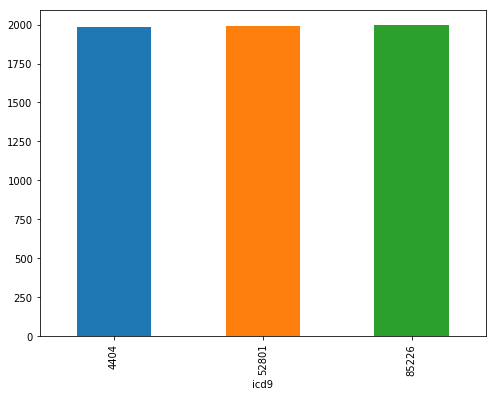

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))

df.groupby('icd9').text.count().plot.bar(ylim=0)
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf = True, 
                        min_df       = 5,
                        norm         = 'l2',
                        encoding     = 'latin-1',
                        ngram_range  = (1, 2),
                        stop_words   = 'english')

features = tfidf.fit_transform(df.text).toarray()
labels   = df.icd9

display(features.shape)

(5970, 58846)

In [23]:
# use chi2 to find terms that are most correlated with each of the ICD9
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for icd9, icd9_id in sorted(icd9_to_id.items()):
    features_chi2 = chi2(features, labels == icd9_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(icd9))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '4404':
  . Most correlated unigrams:
. curb
. current
  . Most correlated bigrams:
. current 54
. zysyn 14
# '52801':
  . Most correlated unigrams:
. curb
. current
  . Most correlated bigrams:
. current 54
. zysyn 14
# '85226':
  . Most correlated unigrams:
. curb
. current
  . Most correlated bigrams:
. current 54
. zysyn 14


### Multi-Class Classifier: Features and Design

__Naive Bayes Classifier__: the one most suitable for word counts is the multinomial variant:

In [31]:
from sklearn.model_selection         import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes             import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['icd9'], random_state=0)
count_vect     = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf  = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [36]:
# make predictions
text1       = df[df['icd9'] == icd9_string[0]]['text']
text_string = text1[2449084]
print(clf.predict(count_vect.transform([text_string])))

['85226']


In [16]:
text2       = df[df['icd9'] == '1987']['text']
text_string = text2[53311]
print(clf.predict(count_vect.transform([text_string])))

['9986']


In [17]:
text3       = df[df['icd9'] == '1505']['text']
text_string = text3[1695246]
print(clf.predict(count_vect.transform([text_string])))

['9986']


### Model Selection
We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.  

We will benchmark the following four models:  
* Random Forest
* Linear Support Vector Machine
* (Multinomial) Naive Bayes
* Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=300, max_depth   =3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV    = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()

MemoryError: 

In [19]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.721108
LogisticRegression        0.694447
MultinomialNB             0.615162
RandomForestClassifier    0.505830
Name: accuracy, dtype: float64

### Model Evaluation

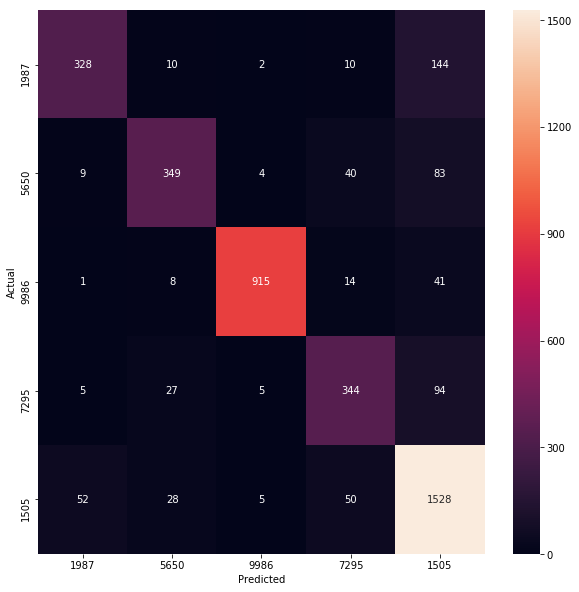

In [20]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax  = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=icd9_id_df.icd9.values,
            yticklabels=icd9_id_df.icd9.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
for predicted in icd9_id_df.icd9_id:
    for actual in icd9_id_df.icd9_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_icd9[actual], id_to_icd9[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['icd9', 'text']])
            print('') 

'1505' predicted as '1987' : 52 examples.


,icd9,text



'1987' predicted as '5650' : 10 examples.


,icd9,text



'7295' predicted as '5650' : 27 examples.


,icd9,text



'1505' predicted as '5650' : 28 examples.


,icd9,text



'1987' predicted as '7295' : 10 examples.


,icd9,text



'5650' predicted as '7295' : 40 examples.


,icd9,text



'9986' predicted as '7295' : 14 examples.


,icd9,text



'1505' predicted as '7295' : 50 examples.


,icd9,text



'1987' predicted as '1505' : 144 examples.


,icd9,text



'5650' predicted as '1505' : 83 examples.


,icd9,text



'9986' predicted as '1505' : 41 examples.


,icd9,text



'7295' predicted as '1505' : 94 examples.


,icd9,text


In [22]:
model.fit(features, labels)
N = 2
for icd9, icd9_id in sorted(icd9_to_id.items()):
    indices = np.argsort(model.coef_[icd9_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(icd9))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# '1505':
  . Top unigrams:
       . fistula
       . tpn
  . Top bigrams:
       . 69 year
       . fistula ______________________________________________________________________________
# '1987':
  . Top unigrams:
       . esophagectomy
       . esophageal
  . Top bigrams:
       . diagnosis esophageal
       . esophageal cancer
# '5650':
  . Top unigrams:
       . metastatic
       . cancer
  . Top bigrams:
       . lung cancer
       . rhythm inferior
# '7295':
  . Top unigrams:
       . 2180
       . 2152
  . Top bigrams:
       . failure ______________________________________________________________________________
       . tracing 2171
# '9986':
  . Top unigrams:
       . infant
       . 2201
  . Top bigrams:
       . fever neutropenia
       . neutropenia ______________________________________________________________________________


In [23]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['icd9'].unique()))

              precision    recall  f1-score   support

        1987       0.83      0.66      0.74       494
        5650       0.83      0.72      0.77       485
        9986       0.98      0.93      0.96       979
        7295       0.75      0.72      0.74       475
        1505       0.81      0.92      0.86      1663

   micro avg       0.85      0.85      0.85      4096
   macro avg       0.84      0.79      0.81      4096
weighted avg       0.85      0.85      0.84      4096

